<a href="https://colab.research.google.com/github/John-Shrestha/DSA/blob/main/MLPC-Individual-Assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [9]:
# Load dataset, remove columns with >50% missing data, and fill remaining missing values (mode for categorical, median for numerical)

df = pd.read_csv('/content/drive/MyDrive/ASSIGN DATASET/National_USFS_Final_Fire_Perimeter_(Feature_Layer).csv')

threshold = 0.5
df = df[df.columns[df.isnull().mean() < threshold]]

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)




/tmp/ipython-input-9-1130875494.py:3: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ASSIGN DATASET/National_USFS_Final_Fire_Perimeter_(Feature_Layer).csv')
/tmp/ipython-input-9-1130875494.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-9-1130875494.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment

In [10]:
# Encode all categorical features and target, then split dataset into features (X) and target variable (y)

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



if 'FIRE_CAUSE' in df.columns:
    target_column = 'FIRE_CAUSE'
else:
    target_column = df.columns[-1]

X = df.drop(target_column, axis=1)
y = df[target_column]


if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y.astype(str))
else:
    y = y.astype(int)


In [11]:
# Split data into train/test sets, inject noise into labels, and train RandomForest using a single CPU core
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

np.random.seed(42)
noise_ratio = 0.15
num_noisy = int(noise_ratio * len(y_train))
noisy_indices = np.random.choice(y_train.index, size=num_noisy, replace=False)
y_train.loc[noisy_indices] = np.random.choice(np.unique(y_train), size=num_noisy)


np.random.seed(42)
noise_ratio_test = 0.15
num_noisy_test = int(noise_ratio_test * len(y_test))
noisy_test_indices = np.random.choice(y_test.index, size=num_noisy_test, replace=False)
y_test.loc[noisy_test_indices] = np.random.choice(np.unique(y_test), size=num_noisy_test)


start_serial = time.time()
rf_serial = RandomForestClassifier(n_jobs=1, random_state=42)
rf_serial.fit(X_train, y_train)
serial_time = time.time() - start_serial
serial_acc = accuracy_score(y_test, rf_serial.predict(X_test))
train_acc_serial = accuracy_score(y_train, rf_serial.predict(X_train))


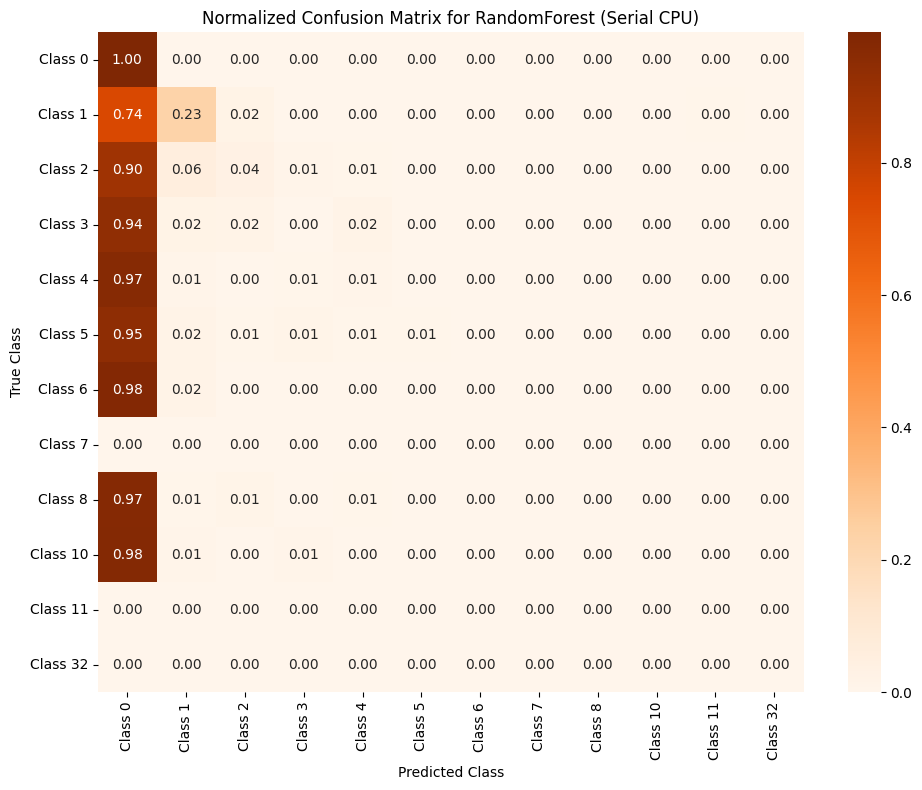

Classification Report (Serial CPU):

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8580
           1       0.56      0.23      0.33       239
           2       0.35      0.04      0.06       200
           3       0.00      0.00      0.00       172
           4       0.25      0.01      0.02       173
           5       0.25      0.01      0.01       160
           6       0.00      0.00      0.00       167
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       158
          10       0.00      0.00      0.00       180
          11       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0

    accuracy                           0.86     10029
   macro avg       0.19      0.11      0.11     10029
weighted avg       0.77      0.86      0.80     10029



In [12]:
# Generate and display normalized confusion matrix and classification report for the serial CPU RandomForest model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_serial = rf_serial.predict(X_test)
labels_serial = sorted(np.unique(np.concatenate((y_test, y_pred_serial))))
cm_serial = confusion_matrix(y_test, y_pred_serial, labels=labels_serial, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_serial, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=[f"Class {i}" for i in labels_serial],
            yticklabels=[f"Class {i}" for i in labels_serial])
plt.title('Normalized Confusion Matrix for RandomForest (Serial CPU)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

print("Classification Report (Serial CPU):\n")
print(classification_report(y_test, y_pred_serial, zero_division=0))


In [13]:
start_parallel = time.time()

In [14]:
# Train RandomForest model using parallel CPU with tuned hyperparameters and measure training time and accuracy

rf_parallel = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    n_estimators=20,
    max_depth=3,
    min_samples_leaf=20,
    min_samples_split=40
)


start_parallel = time.time()
rf_parallel.fit(X_train, y_train)
parallel_time = time.time() - start_parallel



parallel_acc = accuracy_score(y_test, rf_parallel.predict(X_test))


train_acc = accuracy_score(y_train, rf_parallel.predict(X_train))


print(f"Train Accuracy (Parallel): {train_acc:.4f}")
print(f"Test Accuracy (Parallel): {parallel_acc:.4f}")


Train Accuracy (Parallel): 0.8469
Test Accuracy (Parallel): 0.8579


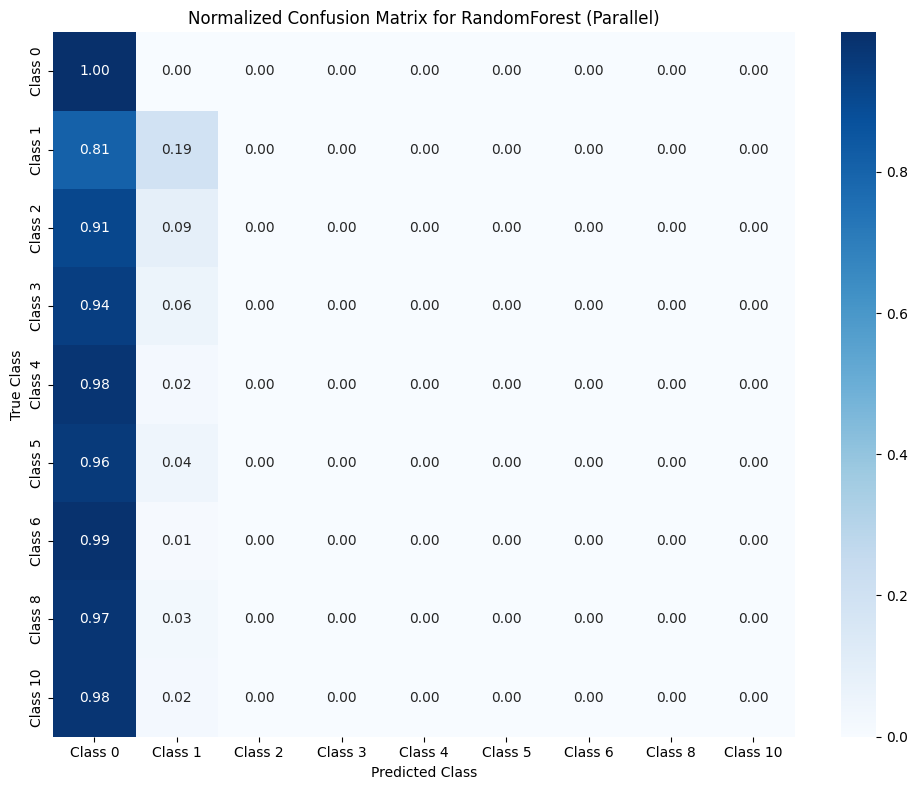

Classification Report:

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      8580
           1       0.39      0.19      0.26       239
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       172
           4       0.00      0.00      0.00       173
           5       0.00      0.00      0.00       160
           6       0.00      0.00      0.00       167
           8       0.00      0.00      0.00       158
          10       0.00      0.00      0.00       180

    accuracy                           0.86     10029
   macro avg       0.14      0.13      0.13     10029
weighted avg       0.75      0.86      0.80     10029



In [15]:
# Generate and display normalized confusion matrix and classification report for the parallel CPU RandomForest model

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_parallel = rf_parallel.predict(X_test)


labels = sorted(np.unique(np.concatenate((y_test, y_pred_parallel))))


cm = confusion_matrix(y_test, y_pred_parallel, labels=labels, normalize='true')


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f"Class {i}" for i in labels],
            yticklabels=[f"Class {i}" for i in labels])
plt.title('Normalized Confusion Matrix for RandomForest (Parallel)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_parallel, zero_division=0))




In [16]:
# Print training time and accuracy for both serial and parallel CPU RandomForest models

print(f"Serial Training Time: {serial_time:.2f}s, Accuracy: {serial_acc:.4f}")
print(f"Parallel Training Time: {parallel_time:.2f}s, Accuracy: {parallel_acc:.4f}")

Serial Training Time: 32.01s, Accuracy: 0.8595
Parallel Training Time: 0.97s, Accuracy: 0.8579


In [17]:
# Train and evaluate XGBoost model using GPU acceleration, including accuracy, confusion matrix, and classification report

try:
    import xgboost as xgb

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    num_classes = len(np.unique(y_train))
    if num_classes > 2:
        objective = 'multi:softmax'
        eval_metric = 'merror'
    else:
        objective = 'binary:logistic'
        eval_metric = 'error'

    params_gpu = {
        'objective': objective,
        'num_class': num_classes if num_classes > 2 else None,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'eval_metric': eval_metric,
        'verbosity': 1
    }


    params_gpu = {k: v for k, v in params_gpu.items() if v is not None}

    start_gpu = time.time()
    model_gpu = xgb.train(params_gpu, dtrain, num_boost_round=100)
    gpu_time = time.time() - start_gpu

    y_pred_gpu = model_gpu.predict(dtest).astype(int)
    gpu_acc = accuracy_score(y_test, y_pred_gpu)


    y_pred_gpu_train = model_gpu.predict(dtrain).astype(int)
    train_acc_gpu = accuracy_score(y_train, y_pred_gpu_train)


    labels_gpu = sorted(np.unique(np.concatenate((y_test, y_pred_gpu))))
    cm_gpu = confusion_matrix(y_test, y_pred_gpu, labels=labels_gpu, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_gpu, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=[f"Class {i}" for i in labels_gpu],
                yticklabels=[f"Class {i}" for i in labels_gpu])
    plt.title('Normalized Confusion Matrix for XGBoost (GPU)')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

    print("Classification Report (GPU):\n")
    print(classification_report(y_test, y_pred_gpu, zero_division=0))
    print(f"Train Accuracy (GPU): {train_acc_gpu:.4f}")
    print(f"Test Accuracy (GPU): {gpu_acc:.4f}")
    print(f"GPU Training Time: {gpu_time:.2f}s")

except Exception as e:
    print("GPU training not available in this environment.")
    print("Reason:", str(e))


GPU training not available in this environment.
Reason: [16:43:39] /workspace/src/objective/multiclass_obj.cu:111: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x79e228a5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xcfe8e7) [0x79e2294fe8e7]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5f8c53) [0x79e228df8c53]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x79e228965a1f]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x79e2a7791e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x79e2a778e493]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x79e2a79f24d8]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x79e2a79f1c8e]
  [bt] (8) /usr/bin

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
# Print a summary comparing training time and accuracy for Serial CPU, Parallel CPU, and GPU (XGBoost) models

print("\n========= Final Comparison Summary =========")
print(f"Serial CPU      - Time: {serial_time:.2f}s | Accuracy: {serial_acc:.4f}")
print(f"Parallel CPU    - Time: {parallel_time:.2f}s | Accuracy: {parallel_acc:.4f}")


if 'gpu_time' in locals() and 'train_acc_gpu' in locals() and 'gpu_acc' in locals():
    print(f"GPU (XGBoost)   - Time: {gpu_time:.2f}s | Train Acc: {train_acc_gpu:.4f} | Test Acc: {gpu_acc:.4f}")
else:
    print("GPU (XGBoost)   - Training not available or failed.")



========= Final Comparison Summary =========
Serial CPU      - Time: 32.01s | Accuracy: 0.8595
Parallel CPU    - Time: 0.97s | Accuracy: 0.8579
GPU (XGBoost)   - Training not available or failed.


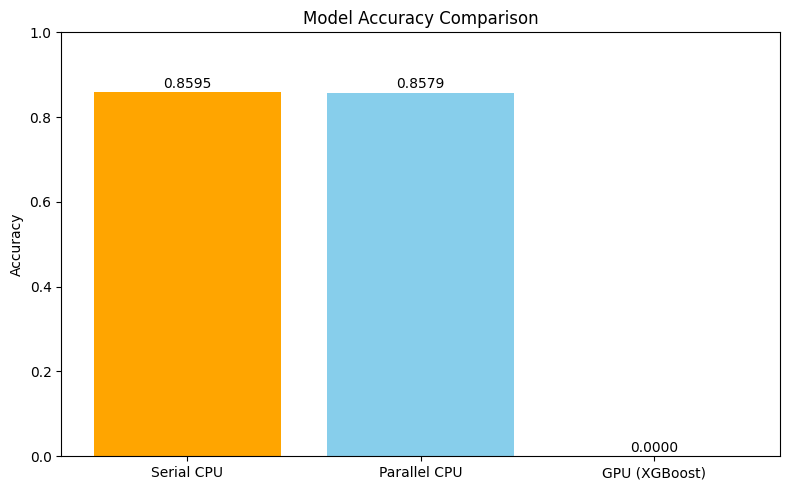

In [19]:
# Plot a bar chart comparing the accuracy of Serial CPU, Parallel CPU, and GPU (XGBoost) models

import matplotlib.pyplot as plt

model_names = ['Serial CPU', 'Parallel CPU', 'GPU (XGBoost)']
accuracies = [serial_acc, parallel_acc, gpu_acc if 'gpu_acc' in locals() else 0]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['orange', 'skyblue', 'green'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center')
plt.tight_layout()
plt.show()


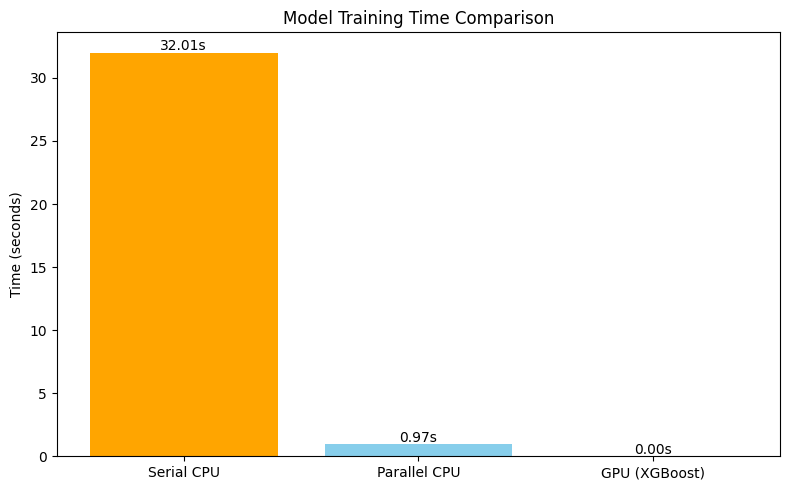

In [20]:
# Plot a bar chart comparing the training times of Serial CPU, Parallel CPU, and GPU (XGBoost) models

training_times = [serial_time, parallel_time, gpu_time if 'gpu_time' in locals() else 0]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, training_times, color=['orange', 'skyblue', 'green'])
plt.title('Model Training Time Comparison')
plt.ylabel('Time (seconds)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.2, f'{yval:.2f}s', ha='center')
plt.tight_layout()
plt.show()


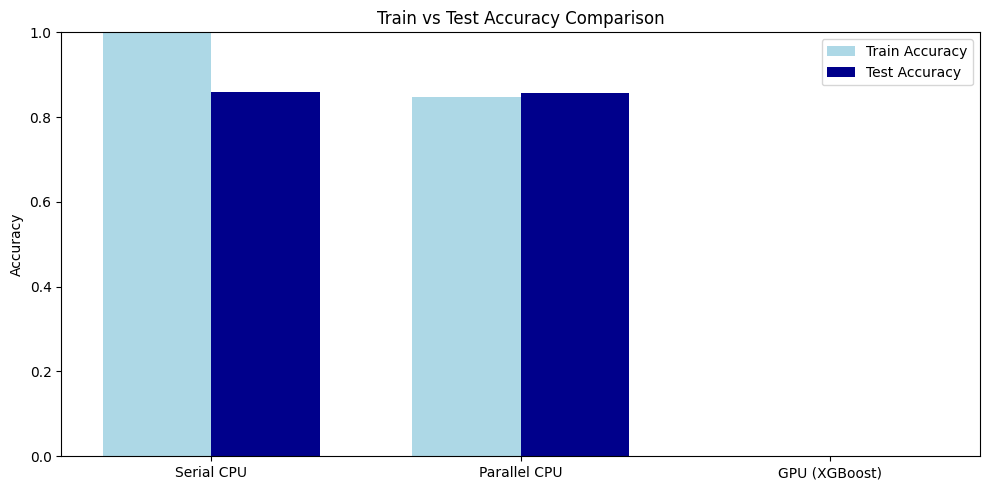

In [21]:
# Plot a grouped bar chart comparing train and test accuracies for Serial CPU, Parallel CPU, and GPU (XGBoost) models

model_names = ['Serial CPU', 'Parallel CPU', 'GPU (XGBoost)']


train_accuracies = [
    train_acc_serial if 'train_acc_serial' in locals() else 0,
    train_acc,
    train_acc_gpu if 'train_acc_gpu' in locals() else 0
]
test_accuracies = [
    serial_acc,
    parallel_acc,
    gpu_acc if 'gpu_acc' in locals() else 0
]


x = range(len(model_names))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], train_accuracies, width, label='Train Accuracy', color='lightblue')
plt.bar([i + width/2 for i in x], test_accuracies, width, label='Test Accuracy', color='darkblue')

plt.xticks(ticks=x, labels=model_names)
plt.ylim(0, 1)
plt.title('Train vs Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
